In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

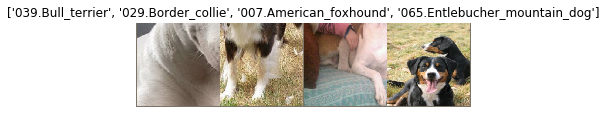

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "saved_models/resnet18_model_{}.model".format(epoch))
                print("Checkpoint saved")                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
len(class_names)

133

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
# fix for cuda error resulting from truncated images
# https://stackoverflow.com/a/23575424/7434289

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 1/10
----------
train Loss: 3.3997 Acc: 0.2251
val Loss: 1.2981 Acc: 0.6108
Checkpoint saved

Epoch 2/10
----------
train Loss: 2.3307 Acc: 0.3996
val Loss: 1.0448 Acc: 0.6814
Checkpoint saved

Epoch 3/10
----------
train Loss: 2.0748 Acc: 0.4630
val Loss: 0.9587 Acc: 0.7126
Checkpoint saved

Epoch 4/10
----------
train Loss: 1.9523 Acc: 0.4879
val Loss: 1.0332 Acc: 0.7006

Epoch 5/10
----------
train Loss: 1.8049 Acc: 0.5162
val Loss: 0.9226 Acc: 0.7246
Checkpoint saved

Epoch 6/10
----------
train Loss: 1.7191 Acc: 0.5467
val Loss: 0.8427 Acc: 0.7389
Checkpoint saved

Epoch 7/10
----------
train Loss: 1.6878 Acc: 0.5488
val Loss: 0.8993 Acc: 0.7377

Epoch 8/10
----------
train Loss: 1.2914 Acc: 0.6606
val Loss: 0.5489 Acc: 0.8347
Checkpoint saved

Epoch 9/10
----------
train Loss: 1.1590 Acc: 0.7022
val Loss: 0.5034 Acc: 0.8467
Checkpoint saved

Epoch 10/10
----------
train Loss: 1.1367 Acc: 0.7090
val Loss: 0.4888 Acc: 0.8431

Training complete in 15m 7s
Best val Acc: 0.846707

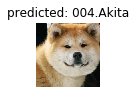

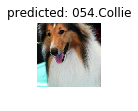

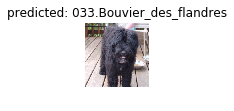

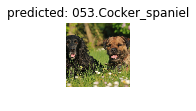

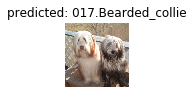

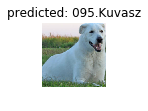

In [12]:
visualize_model(model_ft)

## Inference

In [7]:
# Import needed packages
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
import requests
import shutil
from io import open
import os
from PIL import Image
import json

In [12]:


""" Instantiate model, this downloads tje 4.7 mb  squzzene the first time it is called.
To use with your own model, re-define your trained networks ad load weights as below
checkpoint = torch.load("pathtosavemodel")
model = SimpleNet(num_classes=10)
model.load_state_dict(checkpoint)
model.eval()
"""

# model = squeezenet1_1(pretrained=True)
# model.eval()

# checkpoint = torch.load("saved_models/")
# model = SimpleNet(num_classes=10)
# model.load_state_dict(checkpoint)
# model.eval()

# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load(PATH))
# model.eval()

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# model = model.to(device)

model.load_state_dict(torch.load('saved_models/resnet18_model_8.model'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [15]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 224)
    transformation = transforms.Compose([
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Predict the class of the image
    output = model(input)
    _, pred = torch.max(output, 1)
    
#     index = output.data.numpy().argmax()

    return class_names[pred]

In [16]:
predict_image('dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg')

Prediction in progress


'001.Affenpinscher'

## Notes

1. When you encounter this error, `RuntimeError: cuda runtime error (59) : device-side assert triggered` you may have a mismatch in the expected number of classes (i.e. the number of output nodes in your last fc layer must equal the number of classes in your target data). Once you correct this in the code, you need to restart the kernel and re-run all of the notebook cells. [Here is a link](https://medium.com/@nokkk/notes-for-some-stupid-error-that-i-made-with-pytorch-721ad0397436) describing the issue. 